<a href="https://colab.research.google.com/github/vidhipitroda/Stock-Price-Prediction-with-GenAI-Insights/blob/main/time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import plotly.graph_objs as go
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler

In [ ]:
stock = "AMZN"
data = yf.download([stock], start="2010-01-01", end="2025-03-07")

[*********************100%***********************]  1 of 1 completed


In [ ]:
def calculate_adaptive_envelope_pct(df, window=20):
    """
    Calculate envelope percentage based on market volatility (standard deviation of returns).
    """
    # Calculate daily returns
    returns = df['Close'].pct_change()

    # Calculate volatility (standard deviation of returns) over a rolling window
    volatility = returns.rolling(window=window).std()

    # Normalize the volatility to get a dynamic envelope percentage (e.g., 1-5%)
    envelope_pct = volatility * 2  # Scale the volatility to get an envelope percentage

    # Cap the envelope percentage to a reasonable range
    envelope_pct = envelope_pct.clip(lower=0.01, upper=0.05)  # Cap between 1% and 5%

    return envelope_pct


In [ ]:
def technical_indicators(data, stock_name):


  # Create Simple moving average
  data['20_SMA'] = data['Close'][stock].rolling(window=20).mean()

  # Calculate standard deviation
  data['20SD'] = data['Close'][stock_name].rolling(window=20).std()

  # Create Bollinger Bands
  data['upper_band'] = data['20_SMA'] + (data['20SD'] * 2)
  data['lower_band'] = data['20_SMA'] - (data['20SD'] * 2)


  # Create Exponential moving average
  data['EMA'] = data['Close'].ewm(com=0.5).mean()

  # Calcualte Moving average convergence/divergence (MACD) is a technical indicator
  data['MACD'] = data['Close'].ewm(span=26).mean() - data['Open'].ewm(span=12,adjust=False).mean()

  # Calculate Relative strength index
  rsi_period = 14
  delta = data['Close'].diff()
  gain = (delta.where(delta > 0, 0)).rolling(window=rsi_period).mean()
  loss = (-delta.where(delta < 0, 0)).rolling(window=rsi_period).mean()
  rs = gain / loss
  rsi = 100 - (100 / (1 + rs))
  data['RSI'] = rsi

  # Technical indicator: Rate of Change (ROC)
  data['ROC'] = data['Close'].pct_change(periods=7)

  data['adaptive_envelope_pct'] = calculate_adaptive_envelope_pct(data)

  # removing the first 20 rows
  data = data[20:]

  return data


In [ ]:
features = technical_indicators(data,'AMZN')

In [ ]:
import pandas as pd

def multiindex_to_dataframe(df):
    """
    Converts a DataFrame with a MultiIndex to a DataFrame with a single-level index.

    Args:
        df: DataFrame with a MultiIndex.

    Returns:
        DataFrame with a single-level index, where the MultiIndex levels
        are incorporated into the column names.
    """

    # Create new column names by joining the levels with a separator
    df.columns = df.columns.map(''.join)
    return df

# Convert the MultiIndex DataFrame
features_df = multiindex_to_dataframe(features)

Text(0.5, 1.0, 'Correlation Matrix')

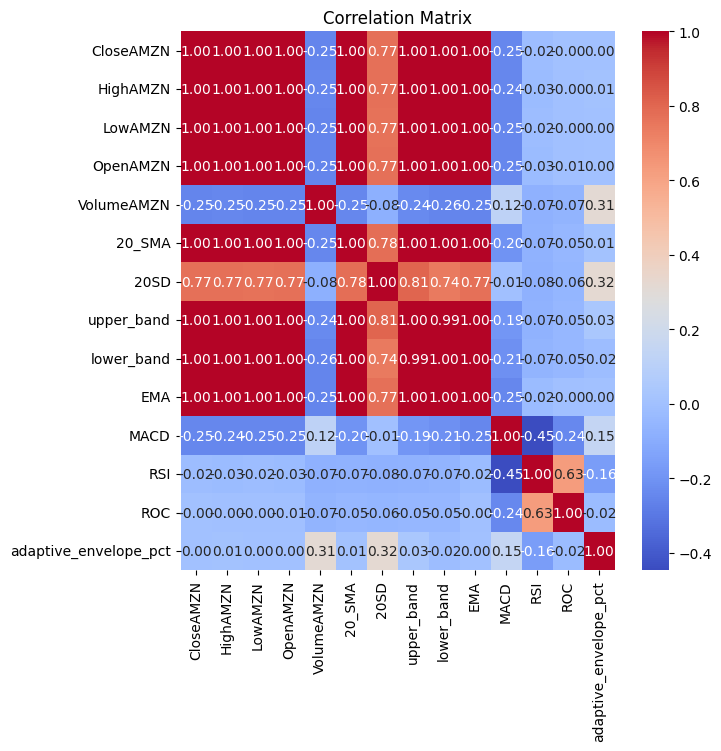

In [ ]:
# Calculate the correlation matrix

corr_matrix = features_df.corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(7, 7))  # Adjust the figure size as needed
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
#plt.show()

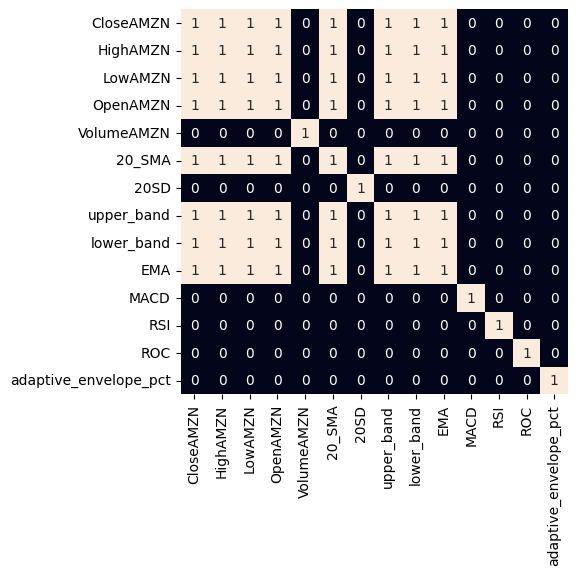

In [ ]:
plt.figure(figsize=(5, 5))
# As our concern is with the highly correlated features.
sb.heatmap(features_df.corr() > 0.9, annot=True, cbar=False)
plt.show()


In [ ]:
def data_preprocessing(features_data):

  """
  Keeping important features for training and implementing normalization on the data

   Args:
   features_data: Total features

   Returns:
   relevent_features: Important features for training (i.e 'MACD','RSI', 'ROC', 'adaptive_envelope_pct', '20SD', 'Volume', 'lower_band', 'upper_band')
   y_scaled: Normalized output (i.e. close stock prices)

  """
  # Removing the highly correlated columns as it will not be helpful in training
  relevent_features = features[['MACD','RSI', 'ROC', 'adaptive_envelope_pct', '20SD', 'Volume' + stock]]

  # Normalization
  scaler = MinMaxScaler()
  relevent_features = scaler.fit_transform(relevent_features)
  y_scaled = scaler.fit_transform(features['Close'+stock].values.reshape(-1,1))

  return relevent_features, y_scaled



In [ ]:
relevent_features, y_scaled = data_preprocessing(features)

In [ ]:
def prepare_data_separate_target(X_data, y_data, time_steps):
    """
    Prepares time series data for an RNN with separate X and y.

    Args:
        X_data: A NumPy array of shape (number_of_samples, number_of_features_X).
                This is your input data.
        y_data: A NumPy array of shape (number_of_samples, number_of_features_y).
                This is your target data.
        time_steps: The number of past time steps to use for prediction.

    Returns:
        X: A NumPy array of shape (number_of_sequences, time_steps, number_of_features_X).
        y: A NumPy array of shape (number_of_sequences, number_of_features_y).
    """

    X = []
    y = []
    for i in range(len(X_data) - time_steps):
        X_sequence = X_data[i:i + time_steps]  # Use X_data for input sequences
        y_target = y_data[i + time_steps]      # Use y_data for targets
        X.append(X_sequence)
        y.append(y_target)

    return np.array(X), np.array(y)


In [ ]:
time_steps = 30
training, outputs = prepare_data_separate_target(relevent_features, y_scaled, time_steps)

print("Shape of features:", training.shape)
print("Shape of output:", outputs.shape)

Shape of features: (3767, 30, 6)
Shape of output: (3767, 1)


In [ ]:
def sequential_split(df, test_size=0.2):
    """
    Splits a pandas DataFrame into training and testing sets sequentially.

    Args:
        df: pandas DataFrame to split (time series data).
        test_size: Proportion of data to use for the test set (e.g., 0.2 for 20%).

    Returns:
        A tuple containing (train_df, test_df).
    """

    split_index = int(len(df) * (1 - test_size))  # Calculate split point
    train_df = df[:split_index]
    test_df = df[split_index:]

    return train_df, test_df


In [ ]:
# Split the data sequentially
X_train, X_test = sequential_split(training, test_size=0.2)
Y_train, Y_test = sequential_split(outputs, test_size=0.2)

In [ ]:
X_train.shape

(3013, 30, 6)

In [ ]:
#input_shape = (timestamp,no of features)
#batch_input_shape = (batch size,timestamp, no of features)
import numpy as np
import tensorflow as tf
import keras
from keras import layers
def create_rnn_model(input_shape):
    """
    Creates an RNN model for time series forecasting.

    Args:
        input_shape: The shape of the input data (time_steps, number_of_features).

    Returns:
        A compiled Keras RNN model.
    """

    model = keras.Sequential()

    # 1. Input Layer (Implicit)
    #    - The input_shape in the first layer defines this.

    # 2. Recurrent Layers

    model.add(layers.GRU(64, return_sequences=True, activation='tanh', input_shape=input_shape))
    model.add(layers.GRU(64, return_sequences=False, activation='tanh'))

    # 3. Dense Layers (Fully Connected)

    model.add(layers.Dense(32, activation='relu'))  # Added Dense layer with ReLU
    model.add(layers.Dense(16, activation='relu'))  # Added another Dense layer

    # 4. Output Layer

    model.add(layers.Dense(1))

    # 5. Compilation

    model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae']) # Added MAE as a metric

    return model


In [ ]:
# Compile the model
model = create_rnn_model((time_steps, 6))
# Fit the model
model.fit(X_train, Y_train, epochs=10)

Epoch 1/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 9s 35ms/step - loss: 0.0425 - mae: 0.1534
Epoch 2/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 0.0048 - mae: 0.0473
Epoch 3/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 0.0027 - mae: 0.0357
Epoch 4/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0024 - mae: 0.0330
Epoch 5/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0022 - mae: 0.0309
Epoch 6/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - loss: 0.0022 - mae: 0.0303
Epoch 7/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0025 - mae: 0.0334
Epoch 8/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0025 - mae: 0.0346
Epoch 9/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 49ms/step - loss: 0.0019 - mae: 0.0300
Epoch 10/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0015 - mae: 0.0259


In [ ]:
# 5. Make Predictions
y_pred_scaled = model.predict(X_test)

# 6. Inverse Transform Predictions
y_pred = scaler.inverse_transform(y_pred_scaled)

y_test_rnn = scaler.inverse_transform(Y_test) # compare with y_test_rnn

# 7. Evaluate Your Model (Optional)
#Mean Squared Error (MSE) & Mean Absolute Error (MAE)
# to evaluate the performance of model on the test data:

mse = mean_squared_error(y_test_rnn, y_pred)
mae = mean_absolute_error(y_test_rnn, y_pred)
print("MSE:", mse)
print("MAE:", mae)

# Now `y_pred` contains predictions in the original scale
print("Shape of predictions:", y_pred.shape)
print("Predictions:", y_pred[0:10])
print("original:", y_test_rnn[0:10])

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
MSE: 396.8838851448054
MAE: 16.079795858260503
Shape of predictions: (754, 1)
Predictions: [[185.75339]
 [186.12195]
 [186.21588]
 [186.68385]
 [187.04585]
 [186.67079]
 [185.72905]
 [184.81277]
 [184.60744]
 [185.01743]]
original: [[176.767297  ]
 [171.22257124]
 [170.24844767]
 [172.45909874]
 [177.56399439]
 [176.68840533]
 [174.20214488]
 [177.9357617 ]
 [181.82106547]
 [184.62118767]]
